In [ ]:
using Pkg
Pkg.activate("NB04")
Pkg.resolve();

In [3]:
using LinearAlgebra, Plots, StatsBase
using RDatasets
using Optim

# Regression

Wir laden den Datensatz `cars` aus dem `RDatasets` package

In [41]:
data_cars = dataset("datasets", "cars");

Wir schauen zunächst, welche Variablen in diesem Datensatz erhalten sind

In [42]:
names(data_cars)

2-element Vector{String}:
 "Speed"
 "Dist"

Die Datenpunkte stellen also Geschwindigkeit und zurückgelegte Distanz dar. 

Wir erwarten einen linearen Zusammenhang, also wählen wir das lineare Modell

$$f_\theta(x) =  a x + b$$

mit $\theta =(a,b)\in\mathbb R^2$.

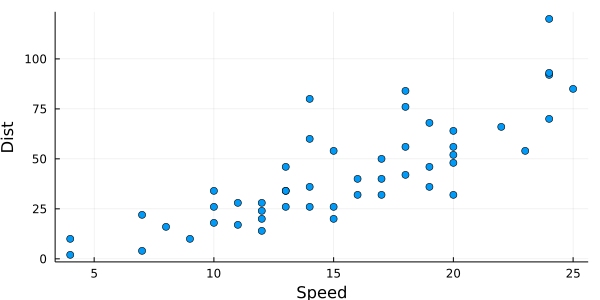

In [62]:
scatter(data_cars[:,"Speed"], data_cars[:,"Dist"], 
            legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))

Wir wollen die lineare Abhängigkeit dieser Variablen mittels Regression schätzen.

Beide Variablen sind eindimensional. D.h:

In [63]:
D = 1; N = 1;

## Aufteilen der Daten

Wir teilen die Daten in Trainings- und Testdaten auf.

Die Wahl soll zufällig sein und $75\%$ der Daten sollen Trainingsdaten sein.

In [64]:
k = size(data_cars, 1)
n = round(Int, k * 0.75);

Die Trainingsdaten speichern wir in den Vektoren `X` und `Y`.

In [65]:
i_training = sample(1:k, n, replace = false)
X = data_cars[i_training,"Speed"]
Y = data_cars[i_training,"Dist"];

Die Testdaten speichern wir in den Vektoren `X_test` und `Y_test`.

In [66]:
i_test = setdiff(1:k, i_training)
X_test = data_cars[i_test,"Speed"]
Y_test = data_cars[i_test,"Dist"];

## Definition des Modells

Wir definieren nun das deterministische lineare Modell $f:\mathbb R^D \to \mathbb R^N$:

In [73]:
f(x::Number, θ) = θ[2] * x + θ[1];

Da $N=1$ können wir für `x` den Typ `Number` angeben. 

Es wird später außerdem hilfreich sein, per Multiple-Dispatch die Definition von `f` auf Vektoren zu erweitern.

In [74]:
f(X::Vector, θ) = [f(x, θ) for x in X]

f (generic function with 2 methods)

Wir definieren weiterhin das statistische Modell für die Varianz $\sigma^2=10$.

In [75]:
σ² = 10
s = sqrt(σ²)
Φ(x::Number, θ) = s * randn() + f(x, θ)
Φ(X::Vector, θ) = [Φ(x, θ) for x in X];

Wir definieren außerdem die Feature Matrix.

In [76]:
Ω = [ones(n) X];

---
## Training

Jetzt trainieren wir unser Modell mit verschiedenen Methoden. 

#### Empirical Risk Minimization

Bei ERM ist der Parameter durch $\theta = \Omega^\dagger Y$ gegeben.

Wir berechnen diesen Parameter wie folgt:

In [78]:
θ_ERM = Ω\Y;

ERM hat die folgenden Parameter für $f_\theta(x)=ax+b$ geschätzt.

In [81]:
println("a = $(θ_ERM[2]), b = $(θ_ERM[1])")

a = 3.704716627048669, b = -14.704091079694726


Wir visualieren die geschätzte Funktion zusammen mit den Trainingsdaten.

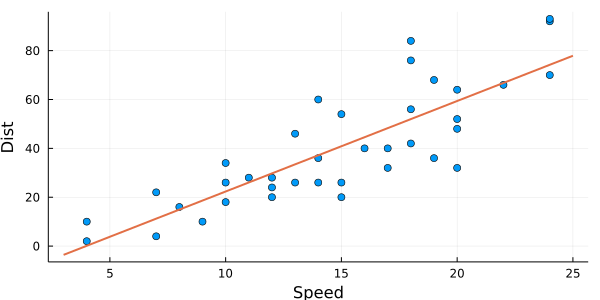

In [82]:
p = collect((minimum(X)-1):(maximum(X)+1))

scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2)

### Ridge Regression

Der Ridge-Regression Schätzer mit Parameter $\lambda$ wird wie folgt berechnet.

In [85]:
θ_T(λ) = (Ω' * Ω + (n*λ) .* diagm(ones(D+1))) \ (Ω' * Y)

θ_T (generic function with 1 method)

Wir plotten den RR-Schätzer für verschiedene Werte von $\lambda$

┌ Info: Saved animation to 
│   fn = /Users/pb/ridge_regression.gif
└ @ Plots /Users/pb/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/Users/pb/ridge_regression.gif")
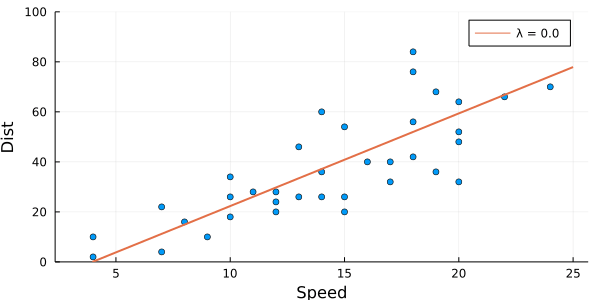

In [89]:
anim = @animate for i in 0:0.02:0.25
    scatter(X,Y, label=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
    plot!(p, f(p, θ_T(i)), lw = 2, label = "λ = $i")
    ylims!(0,100)
end
gif(anim, "/Users/pb/ridge_regression.gif", fps = 3)

Der Animation nach zu urteilen scheint $\lambda=0.2$ eine gute Wahl zu sein.

In [91]:
θ_RR = θ_T(0.2);

RR hat die folgenden Parameter für $f_\theta(x)=ax+b$ geschätzt.

In [92]:
println("a = $(θ_RR[2]), b = $(θ_RR[1])")

a = 3.1299564290827533, b = -5.157137490648899


### Maximum Likelihood und Maximum a-Posteriori Estimation

Der Parameter für ML ist durch `θ_ERM` bestimmt

Der Parameter für MAP ist durch `θ_T(λ)` für $\lambda = \sigma^2/n$ bestimmt.

In [94]:
θ_ML = θ_ERM
θ_MAP = θ_T(σ²/n);

Jetzt können wir diese Parameter in das statistische Modell einsetzen und von diesem samplen. 

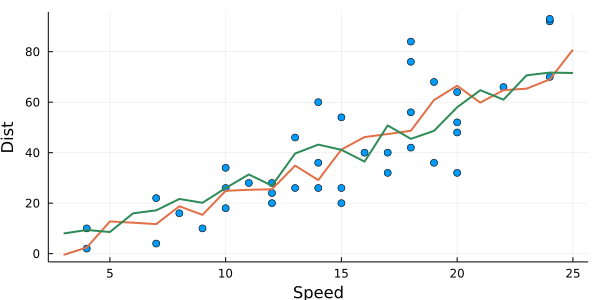

In [96]:
scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, Φ(p, θ_ML), lw = 2)
plot!(p, Φ(p, θ_MAP), lw = 2, c = :seagreen)

### Neural Network

Zuletzt wollen wir die Abhängigkeit von `Dist` und `Speed` durch ein neuronales Netz bestimmen.

Wir verwenden die ReLu Activation Function.

In [98]:
σ(z) = max(0,z);

Wir definieren das Modell durch ein neuronales Netz von Tiefe 2 und mit inneren Layer, der durch lineare Funktionen $\mathbb R^1\to \mathbb R^2$ und $\mathbb R^2\to \mathbb R^1$ gegeben ist. 

Dies ist ein sehr simples neuronales Netz, eignet sich daher aber gut um die Funktionsweise zu veranschaulichen.

In [100]:
function f_NN(x::Number, θ)
    A, b = reshape(θ[1:2], 2, 1), θ[3:4]
    y = σ.(A * x + b)
    
    A, b = reshape(θ[5:6], 1, 2), θ[7:7]
    z = σ.(A * y + b)
    
    z[1]
end
f_NN(X::Vector, θ) = [f_NN(x, θ) for x in X];

Da wir für das neuronale Netz keine geschlossene Form für den ERM-Schätzer `θ_ERM` haben, müssen wir `θ_ERM` durch Optimierungsmethoden bestimmen.

Wir werden die Blackbox `optimize` Funktion aus dem Package `Optim.jl`.

In [101]:
R_NN(θ, X, Y) = mean((f_NN(X, θ) - Y).^2)
o = optimize(θ -> R_NN(θ, X, Y), rand(7))
θ_NN = Optim.minimizer(o);

Das neuronale Netz hat nun eine Funktion geschätzt, die wir wieder zusammen mit den Trainingsdaten visualisieren.

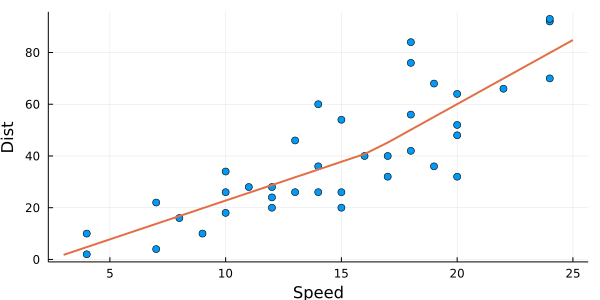

In [104]:
scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f_NN(p, θ_NN), lw = 2)

## Model Selection

Zuletzt wollen wir beurteilen, welches Modell am besten geeignet ist, um die Daten zu beschreiben. Dazu evaluieren wir die Schätzer auf den Testdaten.

Zuerst plotten wir alle geschätzten Funktionen zusammen mit den Testdaten.

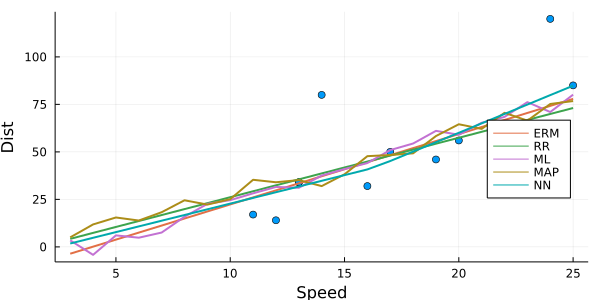

In [112]:
scatter(X_test,Y_test, legend=1,
            label = false,
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2, label = "ERM")
plot!(p, f(p, θ_R), lw = 2, label = "RR")
plot!(p, Φ(p, θ_ML), lw = 2, label = "ML")
plot!(p, Φ(p, θ_MAP), lw = 2, label = "MAP")
plot!(p, f_NN(p, θ_NN), lw = 2, label = "NN")

Um zu beurteilen, welches Modell wie gut funktioniert, definieren wir das empirische Risiko.

In [113]:
R(θ, f, X, Y) = mean((f(X, θ) - Y).^2)

R (generic function with 1 method)

Das empirische Risiko für Trainings- und Testdaten im deterministischen linearen Modell ist wie folgt.

In [114]:
r = [(R(θ, f, X_test, Y_test), R(θ, f, X, Y)) for θ in [θ_ERM, θ_R]]   
println("Risiko Testdaten ERM: $(r[1][1])\n")
println("Risiko Trainingsdaten ERM: $(r[1][2])\n")
println("ERM Risikoverhältnis: $(r[1][1]/r[1][2])\n")
println("Risiko Testdaten RR: $(r[2][1])\n")
println("Risiko Trainingsdaten RR: $(r[2][2])\n")
println("RR Risikoverhältnis: $(r[2][1]/r[2][2])\n")

Risiko Testdaten ERM: 404.2851310539052

Risiko Trainingsdaten ERM: 173.5016349832419

ERM Risikoverhältnis: 2.330151707751654

Risiko Testdaten RR: 437.915904436881

Risiko Trainingsdaten RR: 183.7084203137135

RR Risikoverhältnis: 2.38375521214033



Für das neuronale Netz ergeben sich folgende Werte.

In [115]:
r = (R(θ_NN, f_NN, X_test, Y_test), R(θ_NN, f_NN, X, Y))
println("Risiko Testdaten NN: $(r[1])\n")
println("Risiko Trainingsdaten NN: $(r[2])\n")
println("NN Risikoverhältnis: $(r[1]/r[2])\n")

Risiko Testdaten NN: 383.1390591534273

Risiko Trainingsdaten NN: 166.33235851562375

NN Risikoverhältnis: 2.3034547370855605

